
##**Analisis Descriptivo**

**Preparar notebook**

In [ ]:
## Conectar el notebook a googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Importar librerias necesarias
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from nltk import bigrams
import spacy

In [ ]:
# Descargar spaCy Language Model
!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")

2022-12-05 18:55:46.953360: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


**Carga de los Datos y Creación del *Data Set* para el análisis**

* Conjunto de datos con los registros y todos sus atributos




In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/export.csv', encoding='latin-1')
#Habilitar la siguiente línea para correr el proyecto de manera local
#df1 = pd.read_csv('/content/export.csv', encoding='latin-1')
print(df1.shape)
df1.head(2)

(259762, 15)


,REPORTDATE,WONUM,DESCRIPTION,STATUS,WORKTYPE,ASSETNUM,LOCATION,REGION,ANCESTOR,SOURCESYSID,FAILURECODE,PROBLEMCODE,RESUMEN,WORKLOGID,DETALLE
0,29/05/2022 02:26:00,10016825,Atención Evento M_EPM_EN_4885195,CERRADA,CPROG,NaN,32427-4,METROPOLITANA,R05-14,MAR,POSTE,CAIDO,CIERREOT,2754950,Se revisa y se encuentra poste de 12 MTS de ji...
1,01/09/2022 02:56:24,12523772,Reparar líneas primaria subterránea fallada,CERRADA,CPROG,3206258,32427-4,METROPOLITANA,R05-14,MAR,NaN,NaN,CIERREOT,3005990,Localizar falla circuito primario sub guayabal...


In [ ]:
## Seleccionar registros asociados con tipos de trabajo de interés (Trabajos correctivos)
df1 = df1[df1['WORKTYPE'].isin(['CINME', 'CPROG'])]

In [ ]:
## Seleccionar columnas de interés
df1 = df1[['WORKTYPE', 'REGION', 'ANCESTOR', 'FAILURECODE','PROBLEMCODE','WORKLOGID']].reset_index(drop=True)
print(df1.shape)
df1.head(5)

(158751, 6)


,WORKTYPE,REGION,ANCESTOR,FAILURECODE,PROBLEMCODE,WORKLOGID
0,CPROG,METROPOLITANA,R05-14,POSTE,CAIDO,2754950
1,CPROG,METROPOLITANA,R05-14,NaN,NaN,3005990
2,CINME,METROPOLITANA,R15-20,RED.PRI,FALL.LIN,2634320
3,CINME,METROPOLITANA,R15-20,RED.SEC,FALL.LIN,2634321
4,CINME,METROPOLITANA,R15-20,POSTE,CAIDO,2742512


* Conjunto de datos con los registros (textos) procesados


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/datos_procesados.csv', encoding='latin-1')
#Habilitar la siguiente línea para correr el proyecto de manera local
#df2 = pd.read_csv('/content/datos_preparados.csv', encoding='latin-1')
print(df2.shape)
df2.head(2)

(156792, 7)


,Unnamed: 0,RESUMEN,WORKLOGID,DETALLE,procesado,tokens,tokens_proc
0,0,CIERREOT,2754950,Se revisa y se encuentra poste de 12 MTS de ji...,se revisa y se encuentra poste de metros de ji...,"['se', 'revisa', 'y', 'se', 'encuentra', 'post...","['revisa', 'poste', 'reventado', 'vehiculo', '..."
1,1,CIERREOT,3005990,Localizar falla circuito primario sub guayabal...,localizar falla circuito primario subestacion ...,"['localizar', 'falla', 'circuito', 'primario',...","['localizar', 'falla', 'circuito', 'primario',..."


In [ ]:
## Seleccionar columnas de interés
df2 = df2[['WORKLOGID', 'tokens_proc']]
df2.head(2)

,WORKLOGID,tokens_proc
0,2754950,"['revisa', 'poste', 'reventado', 'vehiculo', '..."
1,3005990,"['localizar', 'falla', 'circuito', 'primario',..."


In [ ]:
## Recuperar los tokes (como lista) que se extrajeron en el textprep y que al exportar el archivo .csv se cargaron como cadenas de texto
df2['tokens_proc'] = df2['tokens_proc'].apply(lambda x: re.sub('[\[\]\']+', '', str(x)))
df2['tokens_proc'] = df2['tokens_proc'].apply(lambda x: x.split(', '))

In [ ]:
df2.head(2)

,WORKLOGID,tokens_proc
0,2754950,"[revisa, poste, reventado, vehiculo, recoje, e..."
1,3005990,"[localizar, falla, circuito, primario, subesta..."




*   Unión de las dos tablas para hacer un analisis descriptivo de los textos y los atributos asociados



In [ ]:
datos = df1.merge(df2, how = 'inner', on='WORKLOGID')
print(datos.shape)
datos.head()

(156792, 7)


,WORKTYPE,REGION,ANCESTOR,FAILURECODE,PROBLEMCODE,WORKLOGID,tokens_proc
0,CPROG,METROPOLITANA,R05-14,POSTE,CAIDO,2754950,"[revisa, poste, reventado, vehiculo, recoje, e..."
1,CPROG,METROPOLITANA,R05-14,NaN,NaN,3005990,"[localizar, falla, circuito, primario, subesta..."
2,CINME,METROPOLITANA,R15-20,RED.PRI,FALL.LIN,2634320,"[retiraron, arbol, palma, aisladero, primario,..."
3,CINME,METROPOLITANA,R15-20,RED.SEC,FALL.LIN,2634321,"[cll, revision, calidad, inspecciona, evidenci..."
4,CINME,METROPOLITANA,R15-20,POSTE,CAIDO,2742512,"[mar, carrera, trabajador, reparan, linea, pri..."


* Añadir columnas con descriptores de los codigos de falla y código de problema

In [ ]:
## Cargar listado códigos de falla
df3 = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/ValoresAnomalias.csv', encoding='latin-1', names = ['FAILURECODE','FALLA'])
#Habilitar la siguiente línea para correr el proyecto de manera local
#df3 = pd.read_csv('/content/ValoresAnomalias.csv', encoding='latin-1', names = ['FAILURECODE','FALLA'])
print('Códigos de Falla')
print(df3.shape)
print(df3.head(5))

## Cargar listado códigos de problema
df4 = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/ValoresProblemas.csv', encoding='latin-1', names = ['PROBLEMCODE','PROBLEMA'])
#Habilitar la siguiente línea para correr el proyecto de manera local
#df4 = pd.read_csv('/content/ValoresProblemas.csv', encoding='latin-1', names = ['PROBLEMCODE','PROBLEMA'])
print('Códigos de Problema')
print(df4.shape)
print(df4.head())

Códigos de Falla
(343, 2)
   FAILURECODE                                        FALLA
0  FAILURECODE                                  DESCRIPTION
1     SERVIDUM                                  SERVIDUMBRE
2     INTERVAC  INTERRUPTOR CON MEDIO DE EXTINCION EN VACIO
3   ENLA.SATEL                             ENLACE SATELITAL
4    CONVER.DC                           CONVERSOR DE AC/DC
Códigos de Problema
(532, 2)
    PROBLEMCODE                    PROBLEMA
0   FAILURECODE                 DESCRIPTION
1  VAL.ALI.N.OP  VALVULA DE ALIVIO NO OPERA
2  BOMB.APAGADA     BOMBA IMPULSORA APAGADA
3          FUGA                        FUGA
4   FALLACIERRE                   NO CIERRA


In [ ]:
datos = datos.merge(df3, how = 'left', on='FAILURECODE')
print(datos.shape)

(156792, 8)


In [ ]:
datos = datos.merge(df4, how = 'left', on='PROBLEMCODE')
print(datos.shape)

(156792, 9)


In [ ]:
print(datos.head())

  WORKTYPE         REGION ANCESTOR FAILURECODE PROBLEMCODE  WORKLOGID  \
0    CPROG  METROPOLITANA   R05-14       POSTE       CAIDO    2754950   
1    CPROG  METROPOLITANA   R05-14         NaN         NaN    3005990   
2    CINME  METROPOLITANA   R15-20     RED.PRI    FALL.LIN    2634320   
3    CINME  METROPOLITANA   R15-20     RED.SEC    FALL.LIN    2634321   
4    CINME  METROPOLITANA   R15-20       POSTE       CAIDO    2742512   

                                         tokens_proc  \
0  [revisa, poste, reventado, vehiculo, recoje, e...   
1  [localizar, falla, circuito, primario, subesta...   
2  [retiraron, arbol, palma, aisladero, primario,...   
3  [cll, revision, calidad, inspecciona, evidenci...   
4  [mar, carrera, trabajador, reparan, linea, pri...   

                                   FALLA                    PROBLEMA  
0                                  POSTE                 POSTE CAIDO  
1                                    NaN                         NaN  
2  RED PRIM

In [ ]:
## Renombrar columnas para facilitar comprensión
columnas = {'WORKTYPE':'TIPO_TRABAJO', 'ANCESTOR':'CIRCUITO', 'FAILURECODE':'COD_FALLA', 'PROBLEMCODE':'COD_PROBLEMA', 'tokens_proc':'TOKENS'}
datos.rename(columns=columnas, inplace = True)
datos.head(2)

,TIPO_TRABAJO,REGION,CIRCUITO,COD_FALLA,COD_PROBLEMA,WORKLOGID,TOKENS,FALLA,PROBLEMA
0,CPROG,METROPOLITANA,R05-14,POSTE,CAIDO,2754950,"[revisa, poste, reventado, vehiculo, recoje, e...",POSTE,POSTE CAIDO
1,CPROG,METROPOLITANA,R05-14,NaN,NaN,3005990,"[localizar, falla, circuito, primario, subesta...",NaN,NaN


**Análisis Descriptivo de las Variables**

In [ ]:
datos[['TIPO_TRABAJO', 'REGION', 'CIRCUITO', 'COD_FALLA', 'COD_PROBLEMA']].describe()

,TIPO_TRABAJO,REGION,CIRCUITO,COD_FALLA,COD_PROBLEMA
count,156792,156770,156785,130774,128848
unique,2,8,882,34,55
top,CINME,METROPOLITANA,409-12,RED.PRI,FALL.LIN
freq,109446,37916,1355,50347,84374


Registros por Región

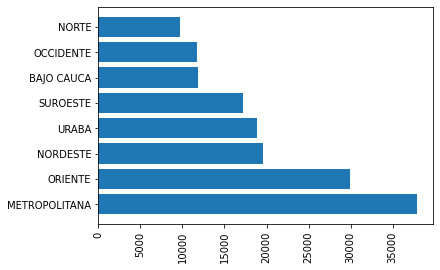

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(datos['REGION'].value_counts().index, datos['REGION'].value_counts())
plt.xticks(rotation=90)
plt.show()

Registros según Cantidad de Circuitos por Región

*   Se construye un indicador para identificar el numero de fallas por región teniendo en cuenta la cantidad de circuitos de cada región de manera que el dato quede "normalizado"



In [ ]:
## Numerador del indicador: Registros por Región
OT_SR = pd.DataFrame(datos.groupby("REGION")["WORKLOGID"].count())
OT_SR

,WORKLOGID
REGION,
BAJO CAUCA,11884
METROPOLITANA,37916
NORDESTE,19533
NORTE,9703
OCCIDENTE,11756
ORIENTE,29936
SUROESTE,17166
URABA,18876


In [ ]:
## Denomidador del indicador: Cantidad de circuitos por región
CTO_SR = pd.DataFrame(datos.groupby("REGION")["CIRCUITO"].unique())
CTO_SR['CIRCUITOS']=CTO_SR['CIRCUITO'].apply(lambda x: len(x))
CTO_SR

,CIRCUITO,CIRCUITOS
REGION,,
BAJO CAUCA,"[302-11, R25-06, R25-03, 316-11, 303-13, 313-1...",42
METROPOLITANA,"[R05-14, R15-20, R09-04, R14-02, R31-03, R12-0...",415
NORDESTE,"[116-12, 165-13, R53-02, R53-43, 113-12, 103-1...",89
NORTE,"[304-11, 304-12, R21-05, R52-01, R39-01, 317-1...",54
OCCIDENTE,"[602-12, 601-42, 601-41, 602-14, 603-16, 601-1...",48
ORIENTE,"[203-11, R16-07, R22-50, 218-13, 205-16, R16-0...",127
SUROESTE,"[502-13, 512-41, 504-15, 504-11, 518-11, 510-4...",80
URABA,"[407-12, 401-14, 404-12, 401-12, 401-11, 411-4...",59


In [ ]:
densidad = OT_SR.merge(CTO_SR, how = 'inner', on='REGION').reset_index()
densidad.head()

,REGION,WORKLOGID,CIRCUITO,CIRCUITOS
0,BAJO CAUCA,11884,"[302-11, R25-06, R25-03, 316-11, 303-13, 313-1...",42
1,METROPOLITANA,37916,"[R05-14, R15-20, R09-04, R14-02, R31-03, R12-0...",415
2,NORDESTE,19533,"[116-12, 165-13, R53-02, R53-43, 113-12, 103-1...",89
3,NORTE,9703,"[304-11, 304-12, R21-05, R52-01, R39-01, 317-1...",54
4,OCCIDENTE,11756,"[602-12, 601-42, 601-41, 602-14, 603-16, 601-1...",48


In [ ]:
## Renombrar columnas para facilitar comprensión
columnas2 = {'WORKLOGID':'CUENTA_OTS', 'CIRCUITOS':'CUENTA_CTOS'}
densidad.rename(columns=columnas2, inplace = True)
densidad.head()

,REGION,CUENTA_OTS,CIRCUITO,CUENTA_CTOS
0,BAJO CAUCA,11884,"[302-11, R25-06, R25-03, 316-11, 303-13, 313-1...",42
1,METROPOLITANA,37916,"[R05-14, R15-20, R09-04, R14-02, R31-03, R12-0...",415
2,NORDESTE,19533,"[116-12, 165-13, R53-02, R53-43, 113-12, 103-1...",89
3,NORTE,9703,"[304-11, 304-12, R21-05, R52-01, R39-01, 317-1...",54
4,OCCIDENTE,11756,"[602-12, 601-42, 601-41, 602-14, 603-16, 601-1...",48


In [ ]:
densidad = densidad[['REGION','CUENTA_OTS','CUENTA_CTOS']]

In [ ]:
## Cantidad de registros según la cantidad de circuitos por región 
densidad['densidad']=densidad['CUENTA_OTS']/densidad['CUENTA_CTOS']
densidad

,REGION,CUENTA_OTS,CUENTA_CTOS,densidad
0,BAJO CAUCA,11884,42,282.952381
1,METROPOLITANA,37916,415,91.363855
2,NORDESTE,19533,89,219.471910
3,NORTE,9703,54,179.685185
4,OCCIDENTE,11756,48,244.916667
5,ORIENTE,29936,127,235.716535
6,SUROESTE,17166,80,214.575000
7,URABA,18876,59,319.932203


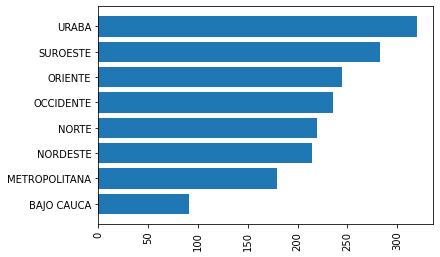

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(densidad['REGION'], densidad['densidad'].sort_values())
plt.xticks(rotation=90)
plt.show()

Registros por Circuito

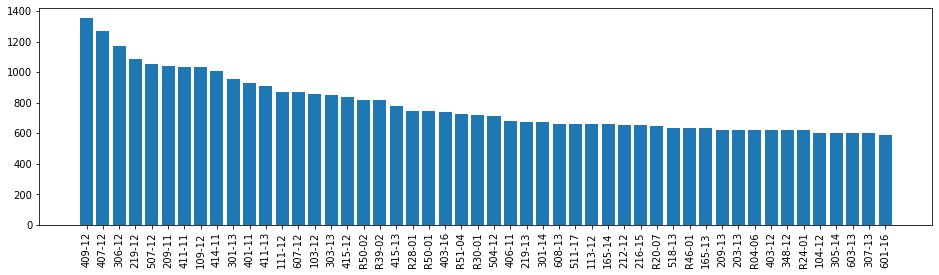

In [ ]:
## Una muestra de los circuitos, los primeros con más casos
circuito = Counter(datos['CIRCUITO'])
top_circuito = circuito.most_common(50)
x,y = zip(*top_circuito)
plt.figure(figsize=(16,4))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

Registros por Tipo de Falla (Las más relevantes por cantidad)

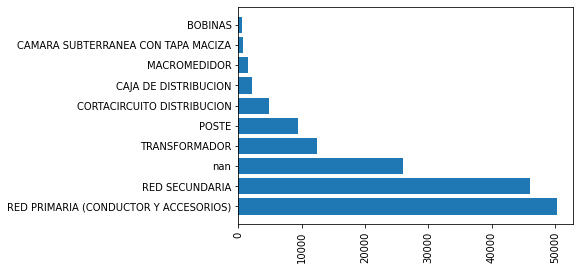

In [ ]:
falla = Counter(datos['FALLA'])
top_fallas = falla.most_common(10)
x,y = zip(*top_fallas)
z = [str(i) for i in list(x)] ## aparece un NaN entre las categorías y hay que convertirlo a string para poder graficar
plt.figure(figsize=(6,4))
plt.barh(z,y)
plt.xticks(rotation=90)
plt.show()

Registros por Tipo de Problema (Los más relevantes por cantidad)

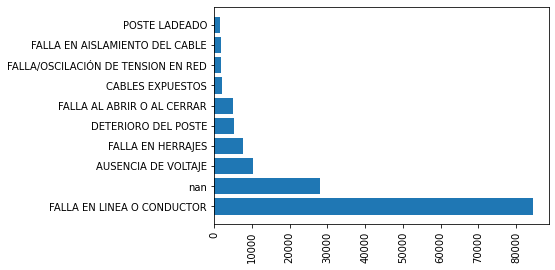

In [ ]:
problema = Counter(datos['PROBLEMA'])
top_problemas = problema.most_common(10)
x,y = zip(*top_problemas)
z = [str(i) for i in list(x)] ## aparece un NaN entre las categorías y hay que convertirlo a string para poder graficar
plt.figure(figsize=(6,4))
plt.barh(z,y)
plt.xticks(rotation=90)
plt.show()

**BoW**

In [ ]:
## Obtener listado de tokens
tokens = []
for t in datos['TOKENS']:
    tokens.extend(t)
print('Cantidad total de tokens = ',str(len(tokens)))
## Distribución de frecuencia de los tokens. Tamaño del BoW
fdist_tokens = nltk.FreqDist(tokens)
print('Tamanno del BoW=',len(fdist_tokens))

Cantidad total de tokens =  1671471
Tamanno del BoW= 11117


In [ ]:
#Extraer el BoW para procesamiento posterior
BoW = pd.DataFrame([[key, fdist_tokens[key]] for key in fdist_tokens.keys()], columns=['palabra', 'frecuencia'])
BoW = BoW.sort_values(by = 'palabra').reset_index(drop=True)
BoW = BoW['palabra']
print(BoW.shape)
BoW.head()

(11117,)


0           
1       aaac
2        aac
3        aal
4    aamalfi
Name: palabra, dtype: object

In [ ]:
##Exportar el BoW para procesamiento posterior
#Exportar la lista de palabras del BoW
#BoW.to_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/bow.csv', index = False, header = False)

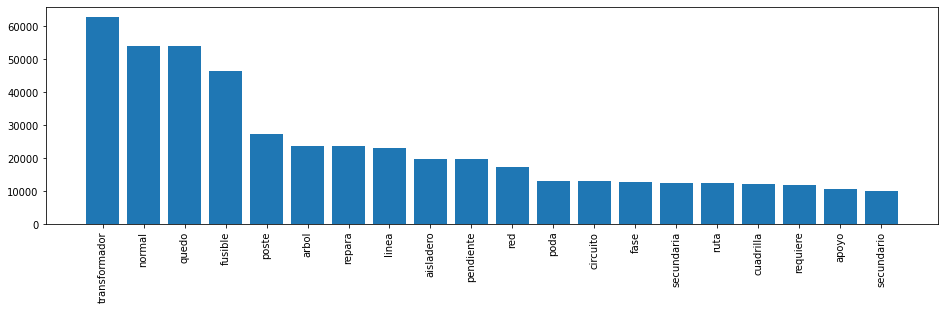

In [ ]:
#Listado de "m" Tokens más comunes
top_tokens = fdist_tokens.most_common(20)
x,y = zip(*top_tokens)
plt.figure(figsize=(16,4))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

Bigramas y Trigramas

In [ ]:
## Distribución de frecuencia de los bigramas.
fdist_bigrams = nltk.FreqDist(bigrams(tokens))
print('Tamanno del listado de bigramas=',len(fdist_bigrams))

Tamanno del listado de bigramas= 417158


In [ ]:
#Listado de "n" bigramas más comunes
top_bigrams = fdist_bigrams.most_common(20)
top_bigrams

[(('quedo', 'normal'), 24644),
 (('fusible', 'transformador'), 14678),
 (('quedo', 'pendiente'), 9121),
 (('transformador', 'quedo'), 7046),
 (('red', 'secundaria'), 5368),
 (('poste', 'secundario'), 4831),
 (('normal', 'fusible'), 4754),
 (('transformador', 'fusible'), 4290),
 (('aguas', 'abajo'), 4179),
 (('fusible', 'quedo'), 3517),
 (('afecto', 'transformador'), 3429),
 (('arbol', 'linea'), 3348),
 (('fusible', 'quemado'), 3321),
 (('quedo', 'normalizado'), 3269),
 (('linea', 'secundaria'), 3030),
 (('fusible', 'aisladero'), 2752),
 (('repara', 'acometida'), 2688),
 (('poste', 'primario'), 2604),
 (('verifica', 'quedo'), 2564),
 (('linea', 'primaria'), 2471)]

In [ ]:
#Listado de "n" bigramas menos comunes
fdist_bigrams.most_common()[-10:]

[(('solo', 'datos'), 1),
 (('datos', 'asi'), 1),
 (('asi', 'entrar'), 1),
 (('entrar', 'sistema'), 1),
 (('sistema', 'dicha'), 1),
 (('dicha', 'encontraba'), 1),
 (('encontraba', 'legalizaron'), 1),
 (('legalizaron', 'llama'), 1),
 (('fotografico', 'presto'), 1),
 (('ingeomega', 'corte'), 1)]

In [ ]:
## Distribución de frecuencia de los trigramas.
fdist_trigrams = nltk.FreqDist(ngrams(tokens,3))
print('Tamanno del listado de bigramas=',len(fdist_trigrams))

Tamanno del listado de bigramas= 987719


In [ ]:
#Listado de "n" trigramas más comunes
top_trigrams = fdist_trigrams.most_common(20)
top_trigrams

[(('transformador', 'quedo', 'normal'), 4351),
 (('fusible', 'transformador', 'quedo'), 2816),
 (('quedo', 'normal', 'fusible'), 2559),
 (('fusible', 'quedo', 'normal'), 2439),
 (('normal', 'fusible', 'transformador'), 1927),
 (('verifica', 'quedo', 'normal'), 1304),
 (('fusible', 'transformador', 'fusible'), 1287),
 (('linea', 'secundaria', 'rota'), 1153),
 (('transformador', 'fusible', 'transformador'), 1107),
 (('quedo', 'normal', 'repara'), 972),
 (('quedo', 'normal', 'reviso'), 956),
 (('quedo', 'pendiente', 'repara'), 954),
 (('repara', 'linea', 'secundaria'), 939),
 (('repara', 'red', 'secundaria'), 894),
 (('quedo', 'normal', 'apoyo'), 778),
 (('repara', 'acometida', 'secundaria'), 735),
 (('linea', 'primaria', 'rota'), 728),
 (('normal', 'quedo', 'pendiente'), 727),
 (('verifica', 'quedo', 'normalizado'), 675),
 (('retiro', 'arbol', 'linea'), 672)]

## Identificación de texto mediano y atípico

In [ ]:
distancia = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/distancias_pendientes.csv', encoding='latin-1')
distancia = distancia[['WORKLOGID','distancia']]
distancia = distancia.sort_values('distancia',ascending=True).reset_index(drop=True)
distancia

,WORKLOGID,distancia
0,2587380,6090.972370
1,2943696,6090.972370
2,2869291,6090.972370
3,2569002,6090.972370
4,2660435,6090.972370
...,...,...
10393,2964823,9511.949139
10394,2823873,9522.836086
10395,2994412,9535.974850
10396,3051481,9545.818148


In [ ]:
id_mediano=distancia.iloc[0,0]
id_mediano

2587380

In [ ]:
id_atipico = distancia.iloc[-1,0]
id_atipico

3207792

In [ ]:
textos = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador/Datos/datos_procesados.csv', encoding='latin-1')

In [ ]:
# texto mediano.
textos[['WORKLOGID','procesado','tokens_proc']][textos['WORKLOGID']==id_mediano]

,WORKLOGID,procesado,tokens_proc
153858,2587380,este evento quedo pendiente para el dia de man...,"['quedo', 'pendiente', 'rural']"


In [ ]:
# texto atipico
textos[['WORKLOGID','procesado','tokens_proc']][textos['WORKLOGID']==id_atipico]

,WORKLOGID,procesado,tokens_proc
63164,3207792,se visita la ruta en la vereda sabanas se entr...,"['ruta', 'sabanas', 'entro', 'intento', 'comun..."
